# Coleta do Dataset ERA-5 e INMET




In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import time as time
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
from pyproj import Transformer
import torch
import matplotlib.pyplot as plt
import os
import shutil
from Dataset_Utils import station_dictionary, grafo_distancias, tensor_data, reset_weights
torch.set_printoptions(threshold=100_000) # or a sufficiently high number
np.set_printoptions(threshold=np.inf)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [60]:
rea = xr.open_dataset(r'C:\Climate Change Project\Datasets\.nc files\era5_precipitation_80-26.nc')


catalogo_inmet = pd.read_csv(r'C:\Climate Change Project\Datasets\Dados INMET\CatalogoEstaçõesAutomáticas.csv', sep=';')

estacoes_RS = station_dictionary(catalogo_inmet)

edge_index = grafo_distancias(stations=estacoes_RS, criterion=120)

print("Dataset com "+str(rea.time.values.shape[0])+" dias")

62
Dataset com 33653 dias


In [61]:
pos = {}
i=0
for name in estacoes_RS.keys():
    pos[i] = float(estacoes_RS[name][1]), float(estacoes_RS[name][0])
    i+=1

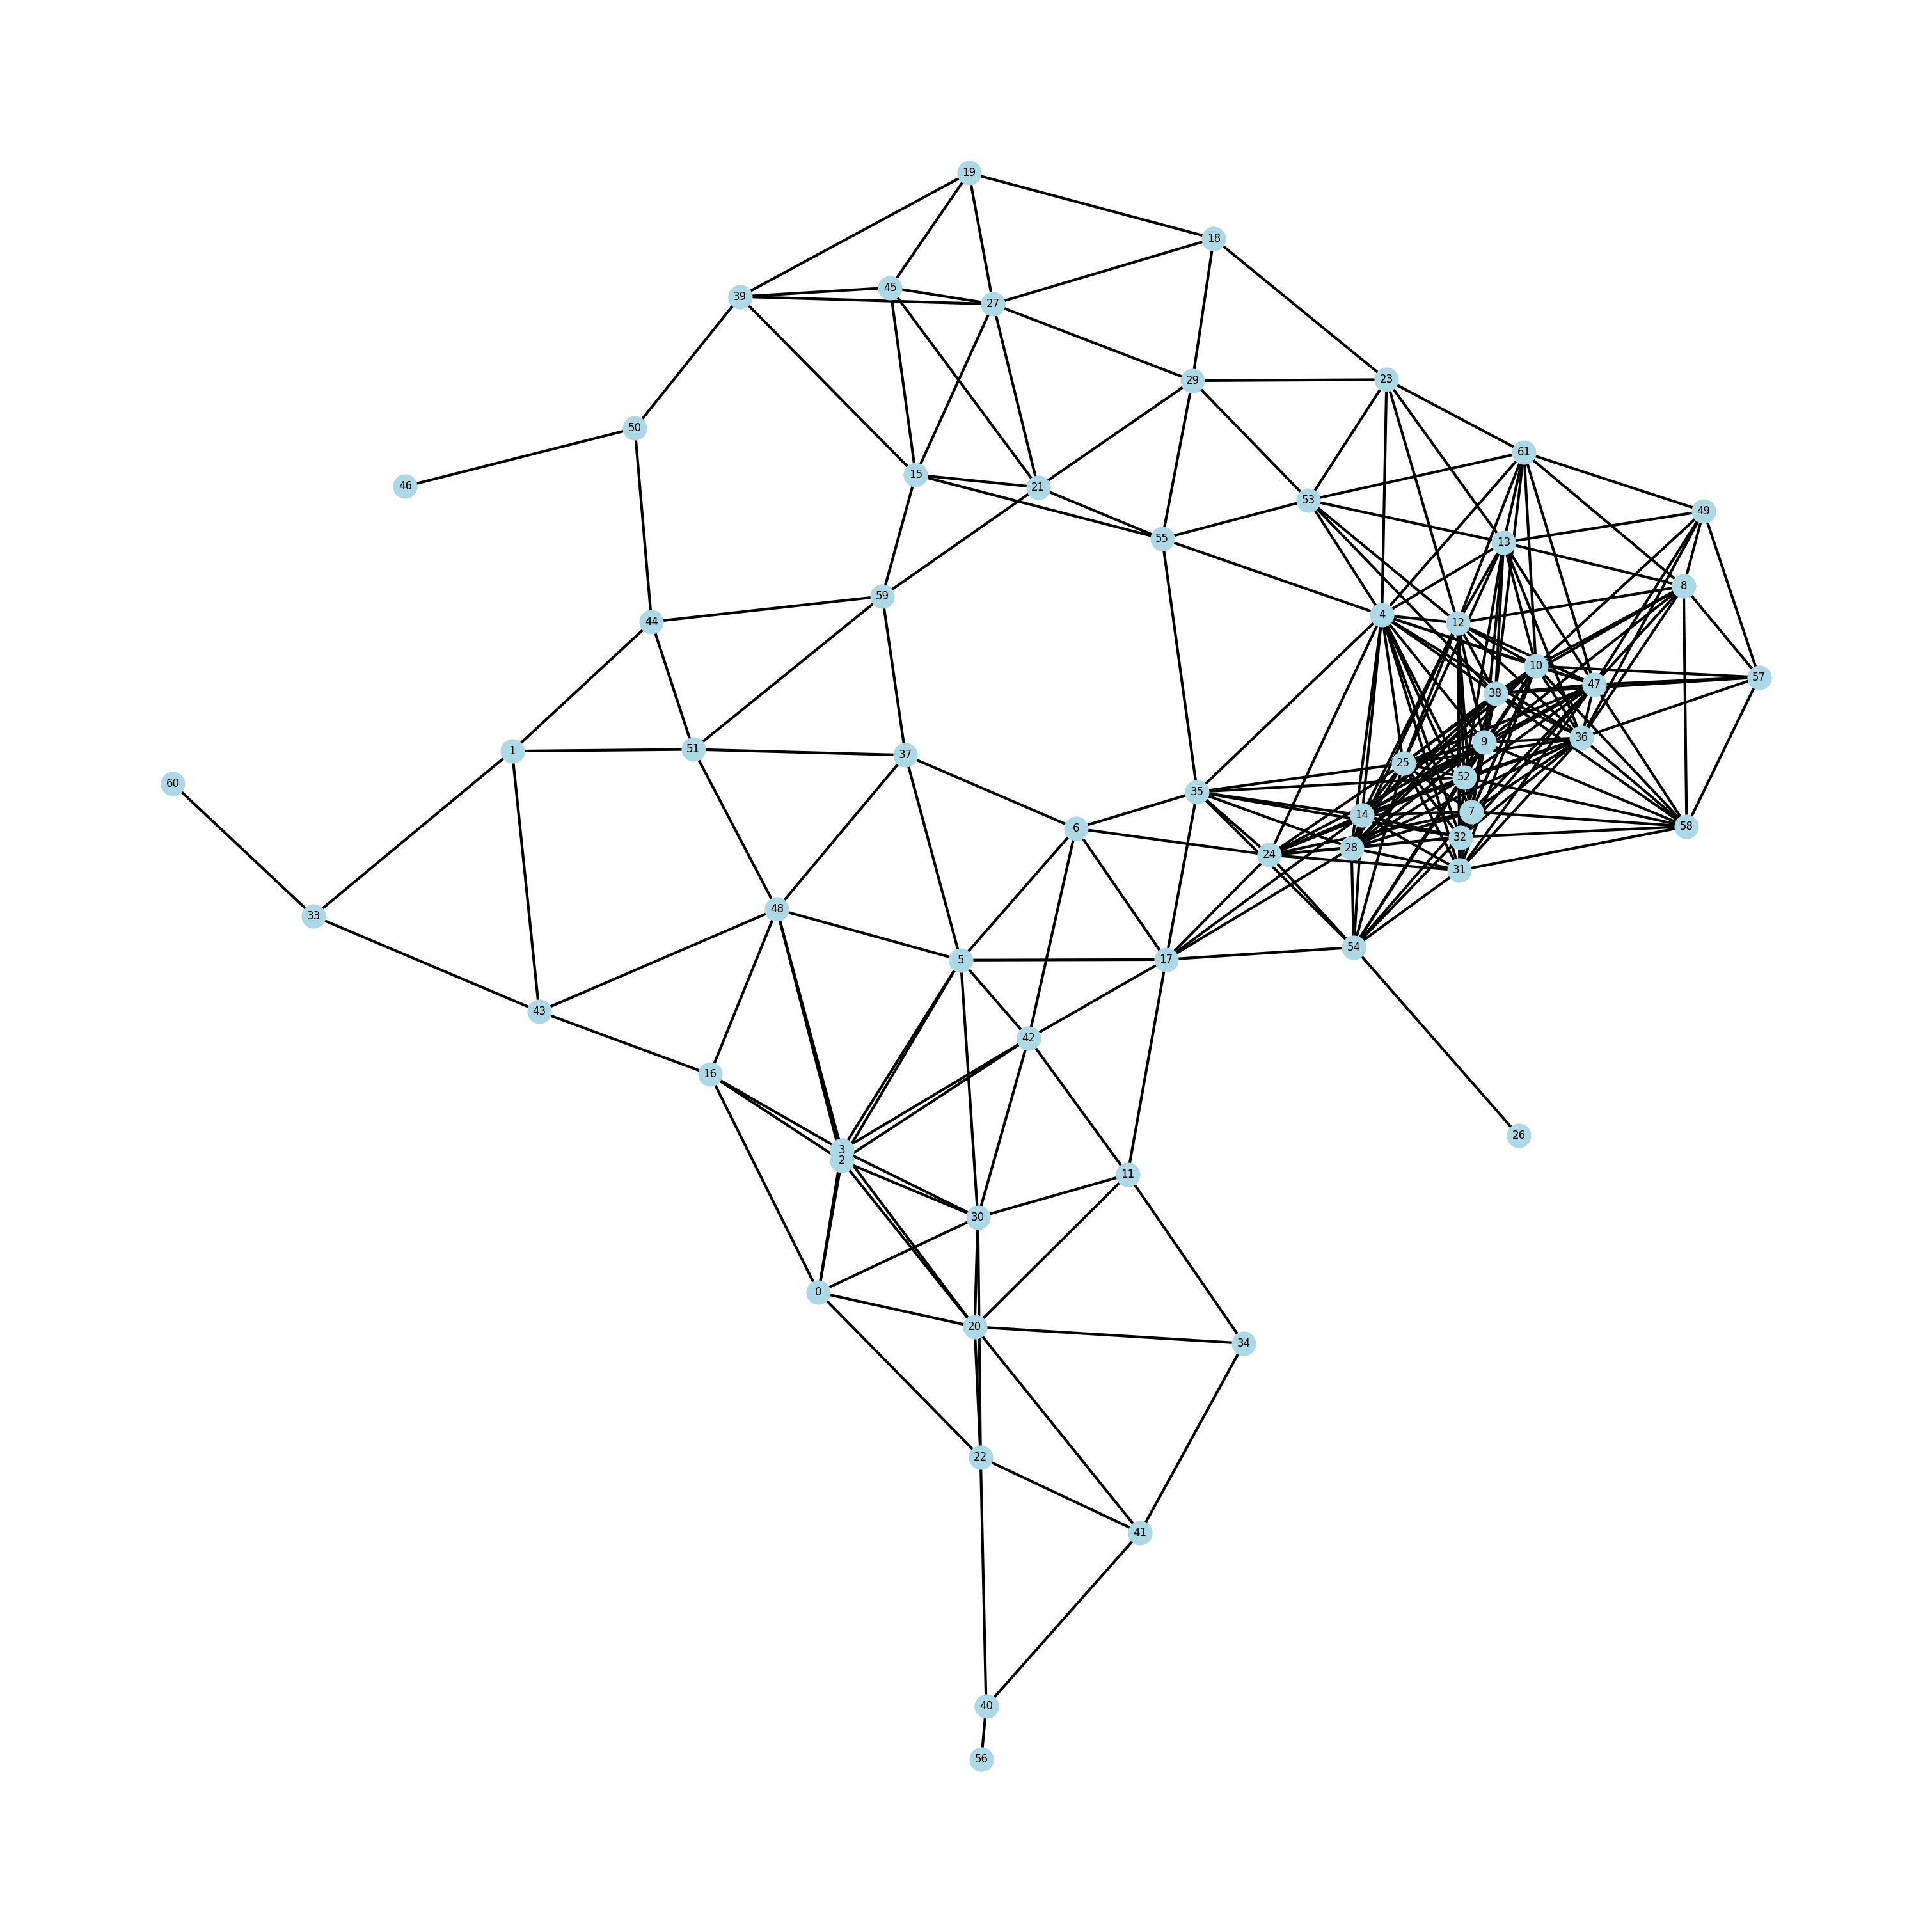

Construido grafo com  62 vértices


In [62]:
import matplotlib.pyplot as plt
transformer = Transformer.from_crs("EPSG:4326", "EPSG:31982", always_xy=True)
graph_data = Data(x=torch.zeros(62), edge_index=edge_index)


G = to_networkx(graph_data, to_undirected=True)

plt.figure(figsize=(30,30))
nx.draw(G,pos,
        with_labels=False,
        node_color='lightblue',
        node_size=700,
        width=3,
        font_weight='bold')



nx.draw_networkx_labels(G,pos,font_color='black')
plt.show()
print("Construido grafo com ",62,"vértices")



In [63]:
from tqdm import tqdm
start_date = "1980-01-01"
pbar = tqdm(total=100)
N = 62
t1 = pd.to_datetime(start_date)
T = rea.time.values.shape[0]-2

X = torch.zeros((T,N,1))
pbar.display()
for t in range(T):
    X[t] = tensor_data(t1+pd.Timedelta(days=t), t1+pd.Timedelta(days=t), rea, estacoes_RS)
    pbar.update(100/T)

pbar.close()

100%|█████████▉| 99.99702832019167/100 [1:47:22<00:00, 62.94s/it]     c:\Users\bruno\OneDrive\Área de Trabalho\venv\.venv\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 100.00000000008232/100 [1:47:23<00:00, 64.43s/it]


In [13]:
from joblib import Parallel, delayed
from tqdm import tqdm

start_date = "1983-01-01"
#end_date = "1992-12-31"

t1 = pd.to_datetime(start_date)
#t2 = pd.to_datetime(end_date)

T = 10

res = Parallel(n_jobs=16)(
    delayed(tensor_data)(t1+pd.Timedelta(days=i),t1+pd.Timedelta(days=i), rea, estacoes_RS) for i in tqdm(range(T))
)

#X_test = torch.stack(res, dim=0).reshape(10,62,1)
#print(X_test.shape)
#print(X_test[0])


100%|██████████| 10/10 [00:00<00:00, 22322.00it/s]


In [64]:
print(X.shape)

#indexes = torch.randperm(X.shape[0])

#shuffled_X = X[indexes]

torch.Size([33651, 62, 1])


In [65]:
def create_train_data(X, period):
    T = X.shape[0]
    Xs, ys = [], []
    #aux_x, aux_y = [], []
    #count = 0
    #var = T
    for t in range(int(T/period)):
        Xs.append(X[t*period:t*period+period-1])
        #print(t*period,t*period+period-1)
        ys.append(X[t*period+period-1])
        #if t+period>=T:
        #    print("ruim")
    return torch.stack(Xs), torch.stack(ys)


Xs, ys = create_train_data(X, period=7)

Xs, ys = 1000*Xs, 1000*ys


print(Xs.shape, ys.shape)

torch.Size([4807, 6, 62, 1]) torch.Size([4807, 62, 1])


In [51]:
from sklearn.preprocessing import MinMaxScaler
B, T, N, _ = Xs.shape
scaler = MinMaxScaler((0,1))
#X_scaled = scaler.fit_transform()

for b in range(B):
    for t in range(T):
        X_scaled = torch.tensor(scaler.fit_transform(Xs[b,t]))
        #print(torch.tensor(X_scaled).shape, Xs[B,t])
        #print(X_scaled.shape, Xs[B,t].shape)
        Xs[b,t] = X_scaled
        #print(Xs[B,t])

    y_scaled = torch.tensor(scaler.fit_transform(ys[b]))
    #print(ys.shape, y_scaled.shape)
    ys[b] = y_scaled

# Modelo de GNN com LSTM



In [66]:
import torch as torch
import torch.nn as nn
from torch_geometric.nn import GCNConv, ChebConv
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import Dataset

In [67]:
import random

def adjacency_matrix(N, edge_index):
    A = torch.zeros((N,N))
    for i in range(0,len(edge_index[0]),2):
        u, v = edge_index[0][i], edge_index[0][i+1]
        A[u,v] = 1
        A[v,u] = 1
    return A

In [55]:
class SpatialGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels,out_channels):
        super().__init__()
        self.in_channels, self.hidden_channels, self.out_channels = in_channels, hidden_channels, out_channels
        self.conv1 = GCNConv(self.in_channels, self.hidden_channels)
        self.conv2 = GCNConv(self.hidden_channels, self.out_channels)
    
    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_weight=None)
        return x

In [68]:
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F


class GLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, adj_matrix):
        super().__init__()
        self.hidden_size = hidden_size
        self.adj = nn.Parameter(adj_matrix)
        
        self.W_i = nn.Linear(input_size+hidden_size, hidden_size)
        self.W_f = nn.Linear(input_size+hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size+hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size+hidden_size, hidden_size)
        
    def forward(self, x, h_prev, c_prev):
        
        #x : (N, input_size)
        #h_prev/c_prev : (N, hidden_size)
        
        combined = torch.cat([x, h_prev], dim=-1)
        
        combined_1 = torch.cat([x,torch.matmul(self.adj,h_prev)], dim=-1)
        
        i = torch.sigmoid(self.W_i(combined))
        f = torch.sigmoid(self.W_f(combined))
        o = torch.sigmoid(self.W_o(combined_1))
        g = torch.tanh(self.W_c(combined_1))
        
        c_t = f*c_prev+i*g
        c_graph = torch.matmul(self.adj, c_t)
        
        h_t = o*torch.tanh(c_graph)
        return h_t, c_t
    
    
    
class GLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, adj_matrix=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cells = nn.ModuleList([GLSTMCell(input_size, hidden_size, adj_matrix) for _ in range(num_layers)])
        
    def forward(self, x_seq, edge_index=None):
        
        #x_seq : (T,N,1)
        #
        
        T, N, _ = x_seq.shape
        h = [torch.zeros(N, self.hidden_size, device=x_seq.device) for _ in range(self.num_layers)]
        c = [torch.zeros(N, self.hidden_size, device=x_seq.device) for _ in range(self.num_layers)]
        
        outputs = []
        
        for t in range(T):
            ht, ct = self.cells[0](x_seq[t],h[0],c[0])
            h[0], c[0] = ht, ct
            outputs.append(ht)
        
        return torch.stack(outputs, dim=0) #(T, N, hidden_size)
        
        
        
class GNN_CHUVA(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_classes=1, num_nodes=62, adj_matrix=None):
        super().__init__()
        self.node_emb = nn.Linear(input_dim, hidden_dim).to(device)
        self.num_nodes = num_nodes
        
        self.conv1 = GCNConv(hidden_dim, hidden_dim).to(device)
        self.conv2 = GCNConv(hidden_dim, hidden_dim).to(device)
        
        self.chebconv1 = ChebConv(in_channels=hidden_dim, out_channels=hidden_dim, K=2)
        self.chebconv2 = ChebConv(in_channels=hidden_dim, out_channels=hidden_dim, K=2)
        
        self.glstm = GLSTM(hidden_dim, hidden_dim, adj_matrix=adj_matrix)
        
        self.pool = global_mean_pool
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, num_classes)
        )
        
    def forward(self, x, edge_index):
        x.to(device)
        edge_index.to(device)
        T, N, _ = x.shape
        
        
        x = self.node_emb(x)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, edge_index)
        T = x.shape[0]
        x_seq = x.view(T, self.num_nodes, -1)
        x_seq = self.glstm(x_seq, edge_index)
        
        #x_pooled = self.pool(x_seq[-1])
        
        out = self.fc(x_seq)
        return out

In [73]:
MAE = nn.L1Loss()
loss_fn = nn.MSELoss()


N = 62

patience = 20
val_error = 0
epochs = 250
T = Xs.shape[0]

path = r"C:\\Climate Change Project\\Sims\\test_lr_1e-2_epochs_"+str(epochs)+"T_"+str(T)

if os.path.exists(path):
    shutil.rmtree(path)

os.mkdir(path)

plt.figure(figsize=(4,4))




model = GNN_CHUVA(hidden_dim=64,adj_matrix=adjacency_matrix(N, edge_index)).to(device)
model.apply(reset_weights)

best_model = model.state_dict()
best_val_loss = float('inf')
val_loss = 0
counter = 0

loss_epochs = []
mae_loss = []
for t in range(Xs.shape[0]):
    X_train = Xs[t].to(device)
    y_train = ys[t].to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2,weight_decay=5e-4)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()
        y_pred = model(X_train.to(device), edge_index.to(device))
        loss = loss_fn(y_pred[-1].to(device), y_train.to(device))
        val_loss = loss.detach().cpu()
        loss.backward()
        optimizer.step()
        if val_loss<best_val_loss:
            counter = 0
            best_model = model.state_dict()
            model.load_state_dict(best_model)
        else:
            counter += 1
        
        if counter>patience:
            model.load_state_dict(best_model)
            print("early stopping")
            break    
    loss_epochs.append(loss.detach().cpu())
    mae_loss.append(MAE(y_pred.to(device)[-1],y_train.to(device)).detach().cpu())
    plt.figure(figsize=(3,3))
    plt.scatter(y_train.detach().cpu(),y_pred.detach().cpu()[-1],label="Dispersão",marker="x")
    plt.plot([0,60],
            [0,60],
            linestyle="--")
    plt.savefig(path+"\\iter"+str(t)+".png")
    plt.close()
    print(f'Iteração {t}:{loss.detach():e}')


plt.plot(loss_epochs)
plt.title("MSE LOSS")
#plt.ylim(0,10)
plt.show()
plt.title("MAE LOSS")
plt.plot(mae_loss)
plt.show()
    

Iteração 0:1.659722e+01
Iteração 1:1.231584e-01
Iteração 2:9.122721e-04
Iteração 3:4.232119e-01
Iteração 4:2.006184e+00
Iteração 5:1.098869e+00
Iteração 6:1.484964e-01
Iteração 7:2.701554e+00
Iteração 8:3.723859e+00
Iteração 9:1.811272e+00
Iteração 10:7.263672e-02
Iteração 11:9.469207e-02
Iteração 12:6.476364e-02
Iteração 13:2.699590e-04
Iteração 14:4.862418e+00
Iteração 15:9.446725e-01
Iteração 16:1.004303e-06
Iteração 17:3.662264e-03
Iteração 18:1.654493e-02
Iteração 19:6.796590e+00
Iteração 20:2.274522e-02
Iteração 21:2.059700e-03
Iteração 22:1.726896e-01
Iteração 23:2.445712e-03
Iteração 24:1.064449e-04
Iteração 25:2.806243e+02
Iteração 26:7.260581e+00
Iteração 27:1.146202e+01
Iteração 28:5.795529e-01
Iteração 29:1.963894e+01
Iteração 30:2.795214e+00
Iteração 31:6.879027e-01
Iteração 32:7.834437e-01
Iteração 33:8.958342e-03
Iteração 34:9.921272e+00
Iteração 35:9.738431e+00
Iteração 36:9.366549e+00
Iteração 37:4.028309e-01
Iteração 38:4.273129e-01
Iteração 39:2.753584e-03
Iteração 4

KeyboardInterrupt: 

<Figure size 400x400 with 0 Axes>

<>:82: SyntaxWarning: invalid escape sequence '\C'
<>:82: SyntaxWarning: invalid escape sequence '\C'
C:\Users\bruno\AppData\Local\Temp\ipykernel_7016\317933538.py:82: SyntaxWarning: invalid escape sequence '\C'
  plt.savefig(f"C:\Climate Change Project\Sims\epoch {epoch}.png", )


torch.Size([33, 29, 62, 1])
Iteração:0:1.050086e+01
Iteração:1:1.550782e+01
Iteração:2:3.827734e+00
Iteração:3:9.649318e-05
Iteração:4:1.362543e+00
Iteração:5:1.737963e-03
Iteração:6:2.167738e+01
Iteração:7:5.556653e-03
Iteração:8:8.328523e-02
Iteração:9:9.677801e+00
Iteração:10:5.011492e-03
Iteração:11:5.977703e-02
Iteração:12:5.124393e+00
Iteração:13:3.829627e-01
Iteração:14:5.431649e-02
Iteração:15:7.866612e-02
Iteração:16:8.939662e-03
Iteração:17:5.767320e+00
Iteração:18:2.459648e-01
Iteração:19:1.813587e-02
Iteração:20:1.043527e+01
Iteração:21:7.991524e-01
Iteração:22:3.311441e+00
Iteração:23:1.045220e+01
Iteração:24:1.090386e-01
Iteração:25:2.089035e+00
Iteração:26:1.087518e-01
Iteração:27:1.231990e+00
Iteração:28:1.165141e-01
Iteração:29:2.709303e+01
Iteração:30:2.657088e+00
Iteração:31:2.149173e+00
Iteração:32:1.361470e-01


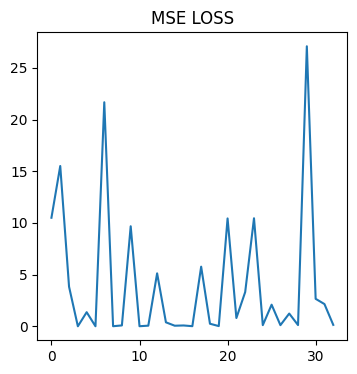

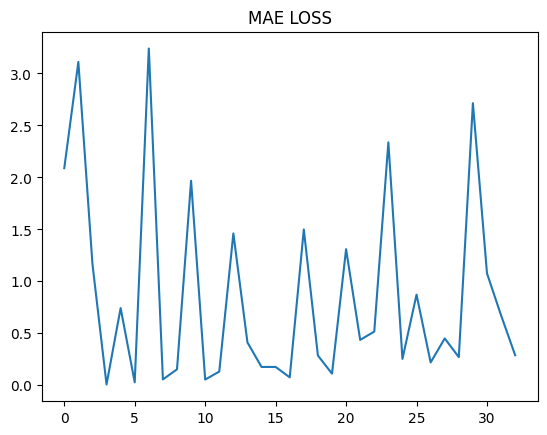

In [ ]:
import matplotlib.pyplot as plt
import os
import shutil

MAE = nn.L1Loss()

N = 62

path = r"C:\Climate Change Project\Sims\test_1"

if os.path.exists(path):
    shutil.rmtree(path)

os.mkdir(path)
plt.figure(figsize=(4,4))





device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GNN_CHUVA(hidden_dim=64,adj_matrix=adjacency_matrix(N, edge_index)).to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

T = Xs.shape[0]
epochs = 300
print(Xs.shape)

loss_epochs = []
mae_loss = []
for t in range(Xs.shape[0]):
    X_train = Xs[t]
    y_train = ys[t]
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=5e-4)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()
        #X_train = Xs[epoch].to(device)
        #y_train = ys[epoch].to(device)
        y_pred = model(X_train.to(device), edge_index.to(device))
        loss = loss_fn(y_pred[-1].to(device), y_train.to(device))
        loss.backward()
        optimizer.step()
    loss_epochs.append(loss.detach().cpu())
    mae_loss.append(MAE(y_pred.to(device)[-1],y_train.to(device)).detach().cpu())
    plt.figure(figsize=(3,3))
    plt.scatter(y_train.detach().cpu(),y_pred.detach().cpu()[-1],label="Dispersão",marker="x")
    plt.plot([0,60],
            [0,60],
            linestyle="--")
    plt.savefig(f"C:\\Climate Change Project\\Sims\\test_1\\epoch {t}.png", )
    plt.close()
    print(f'Iteração:{t}:{loss.detach():e}')
"""
    loss_epochs.append(loss.detach().cpu())
    mae_loss.append(MAE(y_pred, y_train).detach().cpu())
for epoch in range(epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=5e-4)
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    X_train = Xs[epoch].to(device)
    y_train = ys[epoch].to(device)
    y_pred = model(X_train, edge_index.to(device))
    #print(y_pred)
    #print(y_pred.shape, y_train.shape)
    loss = loss_fn(y_pred, y_train)
    mae_loss.append(MAE(y_pred, y_train).detach().cpu())
    print(f'Epoca:{epoch}:{loss.detach():e}')
    #print("y_pred, y_train", y_pred.shape, y_train.shape)
    loss_epochs.append(loss.detach().cpu())
    loss.backward()
    optimizer.step()
    #print("Valores=",y_pred.detach())
    plt.figure(figsize=(3,3))
    plt.scatter(y_train.detach().cpu(),y_pred.detach().cpu()[-1],label="Dispersão",marker="x")
    plt.plot([0,60],
            [0,60],
            linestyle="--")
    plt.savefig(f"C:\Climate Change Project\Sims\epoch {epoch}.png", )
    plt.close()
    #plt.show()
    
    
    #model.eval()
    #optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()
"""

plt.plot(loss_epochs)
plt.title("MSE LOSS")
#plt.ylim(0,10)
plt.show()
plt.title("MAE LOSS")
plt.plot(mae_loss)
plt.show()

In [ ]:
class GCN_LSTM(nn.Module):
    def __init__(self, in_channels, hidden_channels_c, in_channels_t, in_channels_dense,out_channels):
        super().__init__()
        self.in_channels_t, self.out_channels = in_channels_t, out_channels
        self.gcn = SpatialGCN(in_channels, hidden_channels_c, in_channels_t)
        self.lstm = nn.LSTM(in_channels_t, in_channels_dense)
        self.act_f = nn.Sigmoid()
        self.readout = nn.Linear(in_channels_dense, out_channels)
        
    def forward(self, x_seq, edge_index, edge_weight=None,batch=1):
        self.batch = batch
        
        T, N, F = x_seq.shape
        Zs = torch.empty((T,N,self.in_channels_t)).to(device)
        
        for t in range(T):
            xt = x_seq[t,:]
            zt = self.gcn(xt, edge_index)
            Zs[t] = zt

        out = torch.zeros((N,self.out_channels)).to(device)
        for i in range(N):
            output, _ = self.lstm(Zs[:,i,:])[-1]
            output = self.readout(output)
            out[i] = output
        return self.act_f(out)
    
    
class GCN_LSTM_1(nn.Module):
    def __init__(self, N,in_channels, hidden_channels_c, in_channels_t, in_channels_dense,out_channels):
        super().__init__()
        self.gcn = SpatialGCN(in_channels, hidden_channels_c, in_channels_t)
        self.in_channels_t, self.in_channels_dense = in_channels_t, in_channels_dense
        self.act_f = nn.Sigmoid()
        self.readout = nn.Linear(in_channels_dense, out_channels)
        self.lstm = []
        for i in range(N):
            self.lstm.append(nn.LSTM(in_channels_t, in_channels_dense))
        
    def forward(self, x_seq, edge_index, edge_weight=None):
        
        T, N, F = x_seq.shape
        ht, ct = [], []
        
        
        for t in range(T):
            xt = x_seq[t,:]
            for v in range(N):
                if t==0:
                    print("xt.shape=",xt.shape)
                    out_lstm, (ht[v], ct[v]) = self.lstm[v](xt[v])
                    print("c e h shapes=", ht[v].shape, ct[v].shape)
            
        
        return 0

In [ ]:
import matplotlib.pyplot as plt
import os
import shutil
print(N)

path = r"C:\Climate Change Project\Sims"

if os.path.exists(path):
    shutil.rmtree(path)

os.mkdir(path)
plt.figure(figsize=(3,3))





device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GCN_LSTM_1(N=N,in_channels=1, hidden_channels_c=64,in_channels_t=64, in_channels_dense=64, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

epochs = Xs.shape[0]

print(Xs.shape)


for epoch in range(epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2,weight_decay=5e-4)
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    X_train = Xs[epoch].to(device)
    y_train = ys[epoch].to(device)
    y_pred = model(X_train, edge_index.to(device))
    #print(y_pred)
    #print(y_pred.shape, y_train.shape)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    print(f'Epoca:{epoch}:{loss.detach():e}')
    
    #print("Valores=",y_pred.detach())
    plt.figure(figsize=(3,3))
    plt.scatter(y_train.detach().cpu(),y_pred.detach().cpu(),label="Dispersão",marker="x")
    plt.plot([y_train.cpu().min()-0.1, y_train.cpu().max()+0.1],
            [y_train.cpu().min()-0.1, y_train.cpu().max()+0.1],
            linestyle="--")
    plt.savefig(f"C:\Climate Change Project\Sims\epoch {epoch}.png", )
    plt.close()
    #plt.show()
    
    
    #model.eval()
    #optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()
    
    
    

In [ ]:
import matplotlib.pyplot as plt
import os
import shutil

path = r"C:\Climate Change Project\Sims"

if os.path.exists(path):
    shutil.rmtree(path)

os.mkdir(path)
plt.figure(figsize=(3,3))





device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GCN_LSTM(in_channels=1, hidden_channels_c=64,in_channels_t=64, in_channels_dense=64, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

epochs = Xs.shape[0]

print(Xs.shape)


for epoch in range(epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2,weight_decay=5e-4)
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    X_train = Xs[epoch].to(device)
    y_train = ys[epoch].to(device)
    y_pred = model(X_train, edge_index.to(device))
    #print(y_pred)
    #print(y_pred.shape, y_train.shape)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    print(f'Epoca:{epoch}:{loss.detach():e}')
    
    #print("Valores=",y_pred.detach())
    plt.figure(figsize=(3,3))
    plt.scatter(y_train.detach().cpu(),y_pred.detach().cpu(),label="Dispersão",marker="x")
    plt.plot([y_train.cpu().min()-0.1, y_train.cpu().max()+0.1],
            [y_train.cpu().min()-0.1, y_train.cpu().max()+0.1],
            linestyle="--")
    plt.savefig(f"C:\Climate Change Project\Sims\epoch {epoch}.png", )
    plt.close()
    #plt.show()
    
    
    #model.eval()
    #optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()
    
    
    

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GCN_LSTM(input_dim=1, gcn_dim=1, hidden_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 50
batch = 0


for epoch in range(epochs):
    model.train()
    train_loss = 0

    for x, y in train_loader:
        #scaler.fit(x)
        #x = scaler.transform(x)
        #scaler.fit(y)
        #y = scaler.transform(y)
        x, y = x.to(device), y.to(device)
        #print(x.shape,y.shape)
        optimizer.zero_grad()
        pred = model(x.to(device), edge_index.to(device))
        #print("RODOU MODELO")
        loss = loss_fn(pred, y)
        print("loss=",loss)
        loss.backward()
        optimizer.step()
        batch += 1

        train_loss += loss.item()
"""
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x, edge_index.to(device))
            val_loss += loss_fn(pred, y.to(device)).item()

    print(f"Epoch {epoch}: train={train_loss/len(train_loader):.4f}, val={val_loss/len(val_loader):.4f}")

"""


# Temporal Dataset 



In [ ]:
class TemporalGraphDataset(Dataset):
    def __init__(self, X, Y, edge_index, edge_weight=None, window=12, horizon=1):
        """
        X: [T, N, F]
        Y: [T, N]
        N: ordem do graf
        F: número de features
        T: dimensão temporal
        """
        self.X = torch.tensor(X, dtype=torch.float)
        self.Y = torch.tensor(Y, dtype=torch.float)
        
        self.edge_index=edge_index
        self.edge_weight = edge_weight
        
        self.window = window
        self.horizon = horizon
        
        self.T = X.shape[0]
    
    def __len__(self):
        return self.T - self.window - self.horizon+1
        
    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.window]
        y = self.Y[idx+self.window+self.horizon-1]

        
        data = Data(
            x_seq=x_seq,     
            y=y.squeeze(-1),
            edge_index=self.edge_index,
            edge_weight = self.edge_weight
        )
        
        return data
    

In [ ]:
def create_train_data(X, L):
    T = X.shape[0]
    Xs, ys = [], []
    
    for t in range(T-L):
        Xs.append(X[t:t+L])
        ys.append(X[t+L])
    return torch.stack(Xs), torch.stack(ys)


Xs, ys = create_train_data(X,L=6)

print(Xs.shape)
print(ys.shape)


dataset = TemporalGraphDataset(Xs, ys, edge_index=edge_index)

In [ ]:
loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
#from torch_geometric.data import DataLoader
from torch_geometric.loader import DataLoader
num = len(Xs)
train_end=int(0.7*num)
val_end = int(0.85*num)

X_train, y_train = Xs[:train_end], ys[:train_end]
X_val, y_val = Xs[train_end:val_end], ys[train_end:val_end]

X_test, y_test = Xs[val_end:], ys[val_end:]

train_loader = DataLoader(list(zip(X_train,y_train)),batch_size=32, shuffle=False)
val_loader = DataLoader(list(zip(X_val,y_val)), batch_size=32, shuffle=False)

# Loop de treino



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
F = 1
model = GCN_LSTM(input_dim=1, gcn_dim=1,hidden_dim=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

for epoch in range(50):
    model.train()
    total_loss = 0
    
    for batch in loader:
        batch = batch.to(device)
        
        pred = model(batch.x_seq, batch.edge_index)
        loss = loss_fn(pred, batch.y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()